Load the training data.

In [1]:
import gzip
import numpy as np
import matplotlib.pyplot as plt

def load_data(filename, dims):
    with gzip.open(filename, "rb") as infile:
        # consume magic number
        infile.read(4)
        # consume dimensions data
        infile.read(4 * len(dims))

        return np.frombuffer(infile.read(np.prod(dims)), dtype=np.uint8).reshape(dims)

# training data
train_images = load_data("data/train-images-idx3-ubyte.gz", [60000, 28, 28])
train_labels = load_data("data/train-labels-idx1-ubyte.gz", [60000])

# testing data
test_images = load_data("data/t10k-images-idx3-ubyte.gz", [10000, 28, 28])
test_labels = load_data("data/t10k-labels-idx1-ubyte.gz", [10000])

Preprocess images and class labels.

In [2]:
train_x = train_images.astype(np.float) / 255
train_y = np.zeros((60000, 10))
train_y[np.arange(60000),train_labels] = 1

test_x = test_images.astype(np.float) / 255
test_y = np.zeros((10000, 10))
test_y[np.arange(10000),test_labels] = 1

The model has been refactored for simplicity. Redundant operations have been removed, and the gaussian membership function now uses a precision parameter instead of a standard deviation parameter. This enhances the models numerical stability.

Using TensorFlow backend.
W0227 10:28:09.216011 139890924488512 deprecation.py:323] From /home/ryan-desktop/anaconda3/envs/keras/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:102: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 3s 44us/step - loss: 1.5012 - categorical_accuracy: 0.6188 - val_loss: 1.1861 - val_categorical_accuracy: 0.7181
Epoch 2/10
60000/60000 [==============================] - 1s 24us/step - loss: 1.0093 - categorical_accuracy: 0.7328 - val_loss: 0.8851 - val_categorical_accuracy: 0.7492
Epoch 3/10
60000/60000 [==============================] - 1s 24us/step - loss: 0.8020 - categorical_accuracy: 0.7655 - val_loss: 0.7567 - val_categorical_accuracy: 0.7782
Epoch 4/10
60000/60000 [==============================] - 1s 23us/step - loss: 0.6913 - categorical_accuracy: 0.7919 - val_loss: 0.6741 - val_categorical_accuracy: 0.7954
Epoch 5/10
60000/60000 [==============================] - 1s 23us/step - loss: 0.6099 - categorical_accuracy: 0.8215 - val_loss: 0.5955 - val_categorical_accuracy: 0.8204
Epoch 6/10
60000/60000 [==============================] - 1s 24us/step - loss: 0.5489 - categor

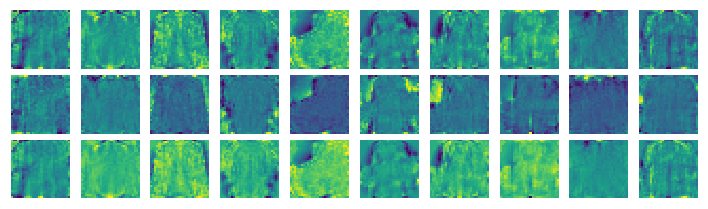

In [3]:
import keras
import keras.layers as layers
import keras.models as models
import keras.backend as K


class LogGaussMF(layers.Layer):
    
    def __init__(
        self, 
        rules,
        mu_initializer="zeros",
        beta_initializer="ones",
        mu_regularizer=None,
        beta_regularizer=None,
        activity_regularizer=None,
        mu_constraint=None,
        beta_constraint="nonneg",
        **kwargs
    ):
        super(LogGaussMF, self).__init__(**kwargs)
        self.rules = int(rules)
        self.mu_initializer = keras.initializers.get(mu_initializer)
        self.beta_initializer = keras.initializers.get(beta_initializer)
        self.mu_regularizer = keras.regularizers.get(mu_regularizer)
        self.beta_regularizer = keras.regularizers.get(beta_regularizer)
        self.mu_constraint = keras.constraints.get(mu_constraint)
        self.beta_constraint = keras.constraints.get(beta_constraint)
        
        
    def build(self, input_shape):
        self.mu = self.add_weight(
            name="mu",
            shape=(self.rules, input_shape[1]),
            initializer=self.mu_initializer,
            regularizer=self.mu_regularizer,
            trainable=True)
        self.beta = self.add_weight(
            name="beta",
            shape=(self.rules, input_shape[1]),
            initializer=self.beta_initializer,
            regularizer=self.beta_regularizer,
            constraint=self.beta_constraint,
            trainable=True)
        super(LogGaussMF, self).build(input_shape)
    
    
    def call(self, x):
        x = K.expand_dims(x, axis=1)
        return -0.5 * K.square(x - self.mu) * self.beta
    
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.rules, input_shape[1])


model = keras.Sequential([
    layers.Reshape((784,), input_shape=(28,28)),
    LogGaussMF(10),
    layers.Lambda(lambda x: K.sum(x, axis=-1)),
    layers.Lambda(lambda x: K.exp(x - K.max(x, axis=-1, keepdims=True))),
    layers.Dense(10, activation="softmax")
])

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=[keras.metrics.categorical_accuracy]
)

history = model.fit(
        x=train_x,
        y=train_y,
        batch_size=128,
        epochs=10,
        validation_data=(test_x, test_y),
        verbose=1,
        shuffle=True
)

mu, beta = model.layers[1].get_weights()

fig, axes = plt.subplots(3, 10, figsize=(10,3))
for i in range(10):
    axes[0][i].imshow(mu[i,:].reshape(28, 28))
    axes[1][i].imshow(beta[i,:].reshape(28, 28))
    axes[2][i].imshow((mu[i,:] * beta[i,:]).reshape(28, 28))

plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0, w_pad=0)

The model is tested with the final linear layer removed.

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 1s 22us/step - loss: 0.6756 - categorical_accuracy: 0.7840 - val_loss: 0.5347 - val_categorical_accuracy: 0.8194
Epoch 2/10
60000/60000 [==============================] - 1s 19us/step - loss: 0.4862 - categorical_accuracy: 0.8372 - val_loss: 0.5035 - val_categorical_accuracy: 0.8229
Epoch 3/10
60000/60000 [==============================] - 1s 19us/step - loss: 0.4516 - categorical_accuracy: 0.8463 - val_loss: 0.4690 - val_categorical_accuracy: 0.8360
Epoch 4/10
60000/60000 [==============================] - 1s 19us/step - loss: 0.4314 - categorical_accuracy: 0.8513 - val_loss: 0.4619 - val_categorical_accuracy: 0.8389
Epoch 5/10
60000/60000 [==============================] - 1s 19us/step - loss: 0.4196 - categorical_accuracy: 0.8553 - val_loss: 0.4528 - val_categorical_accuracy: 0.8429
Epoch 6/10
60000/60000 [==============================] - 1s 19us/step - loss: 0.4091 - categor

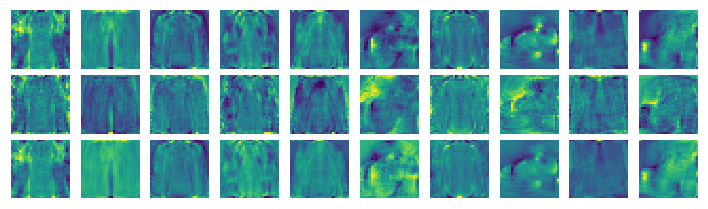

In [4]:
model = keras.Sequential([
    layers.Reshape((784,), input_shape=(28,28)),
    LogGaussMF(10),
    layers.Lambda(lambda x: K.sum(x, axis=-1)),
    layers.Activation("softmax"),
])

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=[keras.metrics.categorical_accuracy]
)

history = model.fit(
        x=train_x,
        y=train_y,
        batch_size=128,
        epochs=10,
        validation_data=(test_x, test_y),
        verbose=1,
        shuffle=True
)

mu, beta = model.layers[1].get_weights()

fig, axes = plt.subplots(3, 10, figsize=(10,3))
for i in range(10):
    axes[0][i].imshow(mu[i,:].reshape(28, 28))
    axes[1][i].imshow(beta[i,:].reshape(28, 28))
    axes[2][i].imshow((mu[i,:] * beta[i,:]).reshape(28, 28))

plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0, w_pad=0)

This seems to slightly increase performance with the same number of rules, and arguably makes the model easier to interpret.

Another idea, is to test is to regularize the mu and beta parameters. The goal is to make the parameterss display better images by reducing noise.

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 1s 23us/step - loss: 2.2002 - categorical_accuracy: 0.7825 - val_loss: 1.9976 - val_categorical_accuracy: 0.8194
Epoch 2/10
60000/60000 [==============================] - 1s 20us/step - loss: 1.8738 - categorical_accuracy: 0.8355 - val_loss: 1.8106 - val_categorical_accuracy: 0.8264
Epoch 3/10
60000/60000 [==============================] - 1s 20us/step - loss: 1.7113 - categorical_accuracy: 0.8442 - val_loss: 1.6795 - val_categorical_accuracy: 0.8341
Epoch 4/10
60000/60000 [==============================] - 1s 20us/step - loss: 1.5978 - categorical_accuracy: 0.8501 - val_loss: 1.5917 - val_categorical_accuracy: 0.8329
Epoch 5/10
60000/60000 [==============================] - 1s 20us/step - loss: 1.5084 - categorical_accuracy: 0.8517 - val_loss: 1.5014 - val_categorical_accuracy: 0.8384
Epoch 6/10
60000/60000 [==============================] - 1s 20us/step - loss: 1.4312 - categor

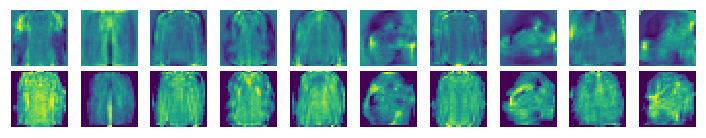

In [5]:
model = keras.Sequential([
    layers.Reshape((784,), input_shape=(28,28)),
    LogGaussMF(10, beta_regularizer=keras.regularizers.l1(0.0002)),
    layers.Lambda(lambda x: K.sum(x, axis=-1)),
    layers.Activation("softmax"),
])

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=[keras.metrics.categorical_accuracy]
)

history = model.fit(
        x=train_x,
        y=train_y,
        batch_size=128,
        epochs=10,
        validation_data=(test_x, test_y),
        verbose=1,
        shuffle=True
)

mu, beta = model.layers[1].get_weights()

fig, axes = plt.subplots(2, 10, figsize=(10,2))
for i in range(10):
    axes[0][i].imshow(mu[i,:].reshape(28, 28))
    axes[1][i].imshow(beta[i,:].reshape(28, 28))

plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0, w_pad=0)

It appears that using regularization has increased the interpretability of the beta parameter, without noticably affecting performance. Regularizing mu did not yield as noticable results.

Performance and interpretability could possibly be increased by using a small amount of dropout on the inputs, reducing the amount of noise the model learns.

W0227 10:28:50.966955 139890924488512 deprecation.py:506] From /home/ryan-desktop/anaconda3/envs/keras/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 1s 25us/step - loss: 2.2074 - categorical_accuracy: 0.7782 - val_loss: 2.0172 - val_categorical_accuracy: 0.8136
Epoch 2/10
60000/60000 [==============================] - 1s 20us/step - loss: 1.8998 - categorical_accuracy: 0.8308 - val_loss: 1.8318 - val_categorical_accuracy: 0.8278
Epoch 3/10
60000/60000 [==============================] - 1s 20us/step - loss: 1.7509 - categorical_accuracy: 0.8391 - val_loss: 1.7113 - val_categorical_accuracy: 0.8300
Epoch 4/10
60000/60000 [==============================] - 1s 20us/step - loss: 1.6487 - categorical_accuracy: 0.8429 - val_loss: 1.6321 - val_categorical_accuracy: 0.8290
Epoch 5/10
60000/60000 [==============================] - 1s 20us/step - loss: 1.5678 - categorical_accuracy: 0.8444 - val_loss: 1.5646 - val_categorical_accuracy: 0.8297
Epoch 6/10
60000/60000 [==============================] - 1s 20us/step - loss: 1.4968 - categor

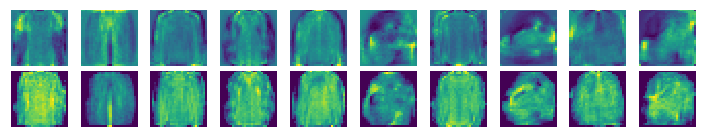

In [6]:
model = keras.Sequential([
    layers.Reshape((784,), input_shape=(28,28)),
    layers.Dropout(0.1),
    LogGaussMF(10, beta_regularizer=keras.regularizers.l1(0.0002)),
    layers.Lambda(lambda x: K.sum(x, axis=-1)),
    layers.Activation("softmax"),
])

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=[keras.metrics.categorical_accuracy]
)

history = model.fit(
        x=train_x,
        y=train_y,
        batch_size=128,
        epochs=10,
        validation_data=(test_x, test_y),
        verbose=1,
        shuffle=True
)

mu, beta = model.layers[2].get_weights()

fig, axes = plt.subplots(2, 10, figsize=(10,2))
for i in range(10):
    axes[0][i].imshow(mu[i,:].reshape(28, 28))
    axes[1][i].imshow(beta[i,:].reshape(28, 28))

plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0, w_pad=0)

Dropout seems to reduce performance slightly, without offering any benefits in terms of performance or interpretability.

Instead of using a dense layer to reduce the ouputs of the rules to the number of classes, the maxout activation could be used to achieve this (implemented using max pooling here). This maintains the interpretability of the model, but restricts the number of rules to a whole number multiple of the number of classes.

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 28us/step - loss: 0.6771 - categorical_accuracy: 0.7834 - val_loss: 0.5390 - val_categorical_accuracy: 0.8159
Epoch 2/10
60000/60000 [==============================] - 1s 22us/step - loss: 0.4845 - categorical_accuracy: 0.8363 - val_loss: 0.4917 - val_categorical_accuracy: 0.8301
Epoch 3/10
60000/60000 [==============================] - 1s 22us/step - loss: 0.4452 - categorical_accuracy: 0.8468 - val_loss: 0.4676 - val_categorical_accuracy: 0.8357
Epoch 4/10
60000/60000 [==============================] - 1s 22us/step - loss: 0.4259 - categorical_accuracy: 0.8522 - val_loss: 0.4647 - val_categorical_accuracy: 0.8368
Epoch 5/10
60000/60000 [==============================] - 1s 23us/step - loss: 0.4125 - categorical_accuracy: 0.8565 - val_loss: 0.4440 - val_categorical_accuracy: 0.8420
Epoch 6/10
60000/60000 [==============================] - 1s 22us/step - loss: 0.4021 - categor

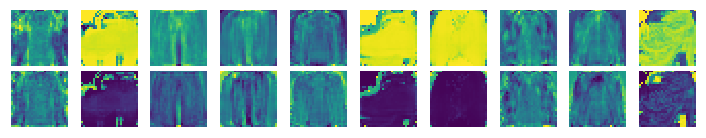

In [15]:
model = keras.Sequential([
    layers.Reshape((784,), input_shape=(28,28)),
    LogGaussMF(20),
    layers.Lambda(lambda x: K.sum(x, axis=-1)),
    layers.Reshape((-1, 1)),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Activation("softmax"),
])

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=[keras.metrics.categorical_accuracy]
)

history = model.fit(
        x=train_x,
        y=train_y,
        batch_size=128,
        epochs=10,
        validation_data=(test_x, test_y),
        verbose=1,
        shuffle=True
)

mu, beta = model.layers[1].get_weights()

fig, axes = plt.subplots(2, 10, figsize=(10,2))
for i in range(10):
    axes[0][i].imshow(mu[i,:].reshape(28, 28))
    axes[1][i].imshow(beta[i,:].reshape(28, 28))

plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0, w_pad=0)

This seems to result in a small improvement in validation accuracy (but this could be because of the removal of the regualrization on beta). Some of the rules do not appear to learn anything and arguably this reduces interpretability.

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 30us/step - loss: 0.6746 - categorical_accuracy: 0.7833 - val_loss: 0.5374 - val_categorical_accuracy: 0.8203
Epoch 2/10
60000/60000 [==============================] - 1s 22us/step - loss: 0.4840 - categorical_accuracy: 0.8388 - val_loss: 0.4927 - val_categorical_accuracy: 0.8305
Epoch 3/10
60000/60000 [==============================] - 1s 22us/step - loss: 0.4489 - categorical_accuracy: 0.8486 - val_loss: 0.4725 - val_categorical_accuracy: 0.8381
Epoch 4/10
60000/60000 [==============================] - 1s 22us/step - loss: 0.4333 - categorical_accuracy: 0.8504 - val_loss: 0.4629 - val_categorical_accuracy: 0.8399
Epoch 5/10
60000/60000 [==============================] - 1s 22us/step - loss: 0.4184 - categorical_accuracy: 0.8554 - val_loss: 0.4666 - val_categorical_accuracy: 0.8385
Epoch 6/10
60000/60000 [==============================] - 1s 22us/step - loss: 0.4082 - categor

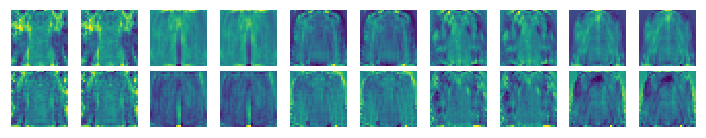

In [17]:
model = keras.Sequential([
    layers.Reshape((784,), input_shape=(28,28)),
    LogGaussMF(20),
    layers.Lambda(lambda x: K.sum(x, axis=-1)),
    layers.Reshape((-1, 1)),
    layers.AveragePooling1D(pool_size=2),
    layers.Flatten(),
    layers.Activation("softmax"),
])

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=[keras.metrics.categorical_accuracy]
)

history = model.fit(
        x=train_x,
        y=train_y,
        batch_size=128,
        epochs=10,
        validation_data=(test_x, test_y),
        verbose=1,
        shuffle=True
)

mu, beta = model.layers[1].get_weights()

fig, axes = plt.subplots(2, 10, figsize=(10,2))
for i in range(10):
    axes[0][i].imshow(mu[i,:].reshape(28, 28))
    axes[1][i].imshow(beta[i,:].reshape(28, 28))

plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0, w_pad=0)